# I'm Something of a Painter Myself - CycleGAN for Monet Style Transfer

####  Github Repository: https://github.com/itsmostafa/monet-painting-gans

## Competition Overview

This notebook implements a **CycleGAN** (Cycle-Consistent Generative Adversarial Network) to transform photographs into Monet-style paintings for the Kaggle ["I'm Something of a Painter Myself"](https://www.kaggle.com/competitions/gan-getting-started) competition.

### Objective
Generate 7,028 Monet-style images from real photographs. The model learns to capture Monet's distinctive impressionist style - soft brushstrokes, natural landscapes, water reflections, and the characteristic color palette.

### Evaluation Metric: MiFID
Submissions are evaluated using **MiFID (Memorization-informed Fréchet Inception Distance)**:
- **FID** measures the similarity between generated images and real Monet paintings using feature distributions from InceptionV3
- **MiFID** penalizes memorization by detecting if generated images are too similar to training images
- **Lower is better** - top submissions achieve scores around 50-100

### Why CycleGAN?
CycleGAN is ideal for unpaired image-to-image translation:
- I don't have paired (photo, monet) examples
- Cycle consistency ensures meaningful transformations (photo→monet→photo ≈ original)
- Two generators learn bidirectional mappings between domains

## 1. Environment Setup and Imports

In [1]:
import random
import itertools
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.6.0+cu124
Using device: cpu


In [ ]:
# Configuration
class Config:
    # Paths
    DATA_DIR = Path('kaggle/input/gan-getting-started')
    MONET_DIR = DATA_DIR / 'monet_jpg'
    PHOTO_DIR = DATA_DIR / 'photo_jpg'
    OUTPUT_DIR = Path('outputs')
    CHECKPOINT_DIR = OUTPUT_DIR / 'checkpoints'
    
    # Image settings
    IMG_SIZE = 256
    IMG_CHANNELS = 3
    
    # Training hyperparameters
    BATCH_SIZE = 1  # CycleGAN works best with batch size 1
    NUM_EPOCHS = 50
    LEARNING_RATE = 2e-4
    BETA1 = 0.5  # Adam beta1
    BETA2 = 0.999  # Adam beta2
    
    # Loss weights
    LAMBDA_CYCLE = 10.0  # Cycle consistency loss weight
    LAMBDA_IDENTITY = 5.0  # Identity loss weight (0.5 * LAMBDA_CYCLE)
    
    # Architecture
    N_RESIDUAL_BLOCKS = 9  # Number of residual blocks in generator
    
    # Training settings
    LR_DECAY_START = 25  # Epoch to start learning rate decay
    SAMPLE_INTERVAL = 500  # Generate samples every N batches
    CHECKPOINT_INTERVAL = 5  # Save checkpoint every N epochs
    
    # Replay buffer size for discriminator training
    BUFFER_SIZE = 50

config = Config()

# Create output directories
config.OUTPUT_DIR.mkdir(exist_ok=True)
config.CHECKPOINT_DIR.mkdir(exist_ok=True)

print("Configuration loaded successfully!")

Configuration loaded successfully!


## 2. Dataset Overview

The dataset consists of two domains:
- **Domain A (Monet)**: 300 Monet paintings at 256x256 pixels
- **Domain B (Photo)**: 7,028 photographs at various sizes (will be resized to 256x256)

In [5]:
# Count images in each directory
monet_files = list(config.MONET_DIR.glob('*.jpg'))
photo_files = list(config.PHOTO_DIR.glob('*.jpg'))

print("Dataset Statistics:")
print(f"{'='*40}")
print(f"Monet paintings: {len(monet_files):,}")
print(f"Photographs:     {len(photo_files):,}")
print(f"{'='*40}")
print(f"\nNote: Photos outnumber Monet paintings by {len(photo_files)/len(monet_files):.1f}x")
print("This is typical for CycleGAN - I cycle through the smaller domain multiple times.")

Dataset Statistics:
Monet paintings: 300
Photographs:     7,038

Note: Photos outnumber Monet paintings by 23.5x
This is typical for CycleGAN - I cycle through the smaller domain multiple times.


## 3. Exploratory Data Analysis (EDA)

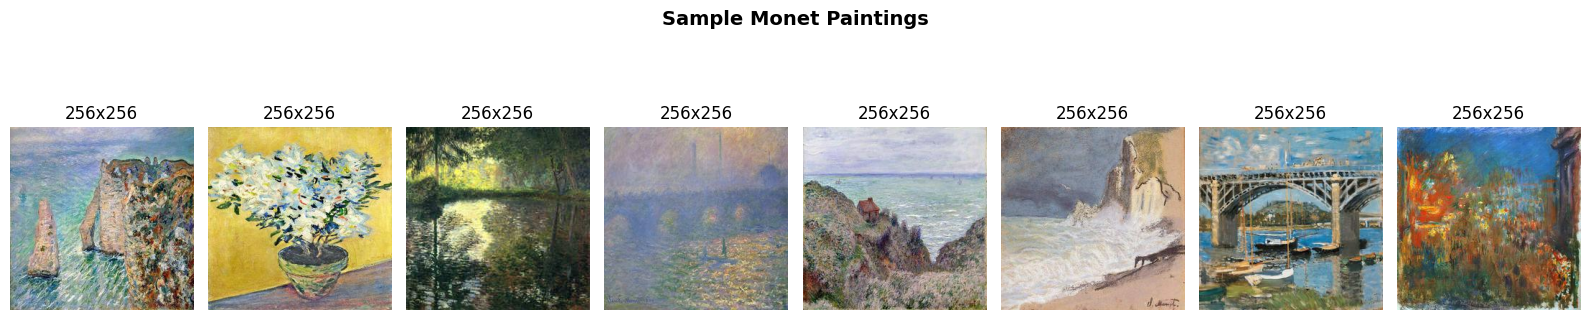

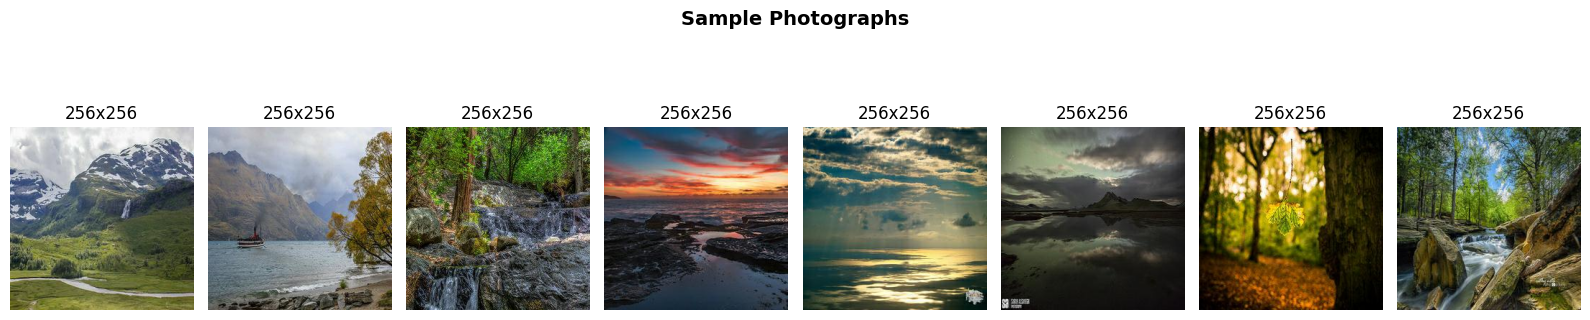

In [6]:
def load_sample_images(file_list, n_samples=8):
    """Load random sample of images for visualization."""
    sample_files = random.sample(file_list, min(n_samples, len(file_list)))
    images = [Image.open(f) for f in sample_files]
    return images

def display_images(images, title, figsize=(16, 4)):
    """Display a row of images."""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    fig.suptitle(title, fontsize=14, fontweight='bold')
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{img.size[0]}x{img.size[1]}')
    plt.tight_layout()
    plt.show()

# Display sample Monet paintings
monet_samples = load_sample_images(monet_files, 8)
display_images(monet_samples, 'Sample Monet Paintings')

# Display sample photographs
photo_samples = load_sample_images(photo_files, 8)
display_images(photo_samples, 'Sample Photographs')

In [7]:
def analyze_image_dimensions(file_list, name, n_samples=None):
    """Analyze image dimensions in a dataset."""
    if n_samples:
        file_list = random.sample(file_list, min(n_samples, len(file_list)))
    
    widths, heights = [], []
    for f in tqdm(file_list, desc=f'Analyzing {name}'):
        img = Image.open(f)
        widths.append(img.size[0])
        heights.append(img.size[1])
    
    return np.array(widths), np.array(heights)

# Analyze dimensions
monet_w, monet_h = analyze_image_dimensions(monet_files, 'Monet')
photo_w, photo_h = analyze_image_dimensions(photo_files, 'Photos', n_samples=500)

print("\nMonet Paintings:")
print(f"  Width:  min={monet_w.min()}, max={monet_w.max()}, mean={monet_w.mean():.1f}")
print(f"  Height: min={monet_h.min()}, max={monet_h.max()}, mean={monet_h.mean():.1f}")
print(f"  All 256x256: {np.all((monet_w == 256) & (monet_h == 256))}")

print("\nPhotographs (sampled):")
print(f"  Width:  min={photo_w.min()}, max={photo_w.max()}, mean={photo_w.mean():.1f}")
print(f"  Height: min={photo_h.min()}, max={photo_h.max()}, mean={photo_h.mean():.1f}")

Analyzing Monet:   0%|          | 0/300 [00:00<?, ?it/s]

Analyzing Photos:   0%|          | 0/500 [00:00<?, ?it/s]


Monet Paintings:
  Width:  min=256, max=256, mean=256.0
  Height: min=256, max=256, mean=256.0
  All 256x256: True

Photographs (sampled):
  Width:  min=256, max=256, mean=256.0
  Height: min=256, max=256, mean=256.0


In [ ]:
def analyze_color_distribution(file_list, name, n_samples=100):
    """Analyze color channel distributions."""
    sample_files = random.sample(file_list, min(n_samples, len(file_list)))
    
    r_values, g_values, b_values = [], [], []
    
    for f in tqdm(sample_files, desc=f'Analyzing {name} colors'):
        img = np.array(Image.open(f).convert('RGB'))
        r_values.extend(img[:, :, 0].flatten())
        g_values.extend(img[:, :, 1].flatten())
        b_values.extend(img[:, :, 2].flatten())
    
    return np.array(r_values), np.array(g_values), np.array(b_values)

# Analyze color distributions
monet_r, monet_g, monet_b = analyze_color_distribution(monet_files, 'Monet', 100)
photo_r, photo_g, photo_b = analyze_color_distribution(photo_files, 'Photos', 100)

# Plot color histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Color Channel Distributions', fontsize=14, fontweight='bold')

colors = ['red', 'green', 'blue']
monet_channels = [monet_r, monet_g, monet_b]
photo_channels = [photo_r, photo_g, photo_b]

for i, (color, monet_ch, photo_ch) in enumerate(zip(colors, monet_channels, photo_channels)):
    # Monet histogram
    axes[0, i].hist(monet_ch, bins=50, color=color, alpha=0.7, density=True)
    axes[0, i].set_title(f'Monet - {color.capitalize()} Channel')
    axes[0, i].set_xlim(0, 255)
    
    # Photo histogram
    axes[1, i].hist(photo_ch, bins=50, color=color, alpha=0.7, density=True)
    axes[1, i].set_title(f'Photos - {color.capitalize()} Channel')
    axes[1, i].set_xlim(0, 255)

plt.tight_layout()
plt.show()

# Print statistics
print("\nColor Statistics:")
print(f"{'Channel':<10} {'Monet Mean':<12} {'Photo Mean':<12} {'Difference':<12}")
print(f"{'-'*46}")
for ch, m_ch, p_ch in zip(['Red', 'Green', 'Blue'], monet_channels, photo_channels):
    m_mean = np.mean(m_ch)
    p_mean = np.mean(p_ch)
    print(f"{ch:<10} {m_mean:<12.2f} {p_mean:<12.2f} {m_mean - p_mean:<12.2f}")

In [ ]:
# Side-by-side comparison: Monet style characteristics
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Style Comparison: Monet vs Photographs', fontsize=14, fontweight='bold')

for i in range(4):
    monet_img = Image.open(random.choice(monet_files))
    photo_img = Image.open(random.choice(photo_files)).resize((256, 256))
    
    axes[0, i].imshow(monet_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Monet', fontsize=12)
    
    axes[1, i].imshow(photo_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Photos', fontsize=12)

plt.tight_layout()
plt.show()

print("\nKey Style Differences:")
print("- Monet: Soft brushstrokes, impressionist style, warm color palette")
print("- Monet: Often features water, gardens, nature scenes")
print("- Photos: Sharp edges, realistic colors, varied subjects")
print("- Challenge: Transform photo realism into impressionist softness")

## 4. Data Loading Pipeline

In [ ]:
class MonetDataset(Dataset):
    """Dataset for loading Monet paintings and photographs."""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_files = sorted(list(self.root_dir.glob('*.jpg')))
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image


class CycleGANDataset(Dataset):
    """Combined dataset for CycleGAN training.
    
    Pairs images from two domains (Monet and Photos).
    Since the datasets have different sizes, I cycle through the smaller one.
    """
    
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_dataset = MonetDataset(monet_dir, transform)
        self.photo_dataset = MonetDataset(photo_dir, transform)
        
        self.monet_len = len(self.monet_dataset)
        self.photo_len = len(self.photo_dataset)
        
    def __len__(self):
        return max(self.monet_len, self.photo_len)
    
    def __getitem__(self, idx):
        monet_idx = idx % self.monet_len
        photo_idx = idx % self.photo_len
        
        monet_img = self.monet_dataset[monet_idx]
        photo_img = self.photo_dataset[photo_idx]
        
        return {'monet': monet_img, 'photo': photo_img}

In [ ]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE + 30, config.IMG_SIZE + 30)),  # Slight upscale for random crop
    transforms.RandomCrop(config.IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets and dataloaders
train_dataset = CycleGANDataset(
    monet_dir=config.MONET_DIR,
    photo_dir=config.PHOTO_DIR,
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for debugging, increase for performance
    pin_memory=True if device.type == 'cuda' else False
)

# Dataset for inference (photos only, no augmentation)
photo_dataset = MonetDataset(config.PHOTO_DIR, transform=test_transform)
photo_loader = DataLoader(photo_dataset, batch_size=1, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

In [ ]:
# Visualize a training batch
def denormalize(tensor):
    """Convert tensor from [-1, 1] to [0, 1] for visualization."""
    return (tensor + 1) / 2

sample_batch = next(iter(train_loader))
monet_sample = sample_batch['monet']
photo_sample = sample_batch['photo']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(denormalize(monet_sample[0]).permute(1, 2, 0).numpy())
axes[0].set_title('Monet (normalized)')
axes[0].axis('off')

axes[1].imshow(denormalize(photo_sample[0]).permute(1, 2, 0).numpy())
axes[1].set_title('Photo (normalized)')
axes[1].axis('off')

plt.suptitle('Sample Training Batch', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. CycleGAN Architecture

CycleGAN consists of:
1. **Two Generators (G_AB, G_BA)**: Transform images between domains
   - G_AB: Photo → Monet (what we need for submission)
   - G_BA: Monet → Photo
2. **Two Discriminators (D_A, D_B)**: Distinguish real from fake images
   - D_A: Distinguish real Monet from fake Monet
   - D_B: Distinguish real Photo from fake Photo

### Generator Architecture
I use a ResNet-based generator with:
- Downsampling encoder (3 conv layers)
- 9 Residual blocks
- Upsampling decoder (3 deconv layers)
- Instance Normalization (better for style transfer than BatchNorm)

In [ ]:
class ResidualBlock(nn.Module):
    """Residual block with two convolutions and instance normalization."""
    
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    """ResNet-based Generator for CycleGAN.
    
    Architecture:
    - c7s1-64: 7x7 Conv, 64 filters, stride 1
    - d128: 3x3 Conv, 128 filters, stride 2 (downsample)
    - d256: 3x3 Conv, 256 filters, stride 2 (downsample)
    - R256 x 9: 9 Residual blocks with 256 filters
    - u128: 3x3 Deconv, 128 filters, stride 2 (upsample)
    - u64: 3x3 Deconv, 64 filters, stride 2 (upsample)
    - c7s1-3: 7x7 Conv, 3 filters, stride 1 (output)
    """
    
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=9):
        super().__init__()
        
        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]
        
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=0),
            nn.Tanh()  # Output in [-1, 1]
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    """PatchGAN Discriminator.
    
    Outputs a grid of predictions (70x70 receptive field patches).
    Each cell classifies whether the corresponding patch is real or fake.
    
    Architecture:
    - C64: 4x4 Conv, 64 filters, stride 2, no norm
    - C128: 4x4 Conv, 128 filters, stride 2
    - C256: 4x4 Conv, 256 filters, stride 2
    - C512: 4x4 Conv, 512 filters, stride 1
    - Output: 4x4 Conv, 1 filter, stride 1
    """
    
    def __init__(self, in_channels=3):
        super().__init__()
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize models
G_AB = Generator(n_residual_blocks=config.N_RESIDUAL_BLOCKS).to(device)  # Photo -> Monet
G_BA = Generator(n_residual_blocks=config.N_RESIDUAL_BLOCKS).to(device)  # Monet -> Photo
D_A = Discriminator().to(device)  # Discriminator for Monet domain
D_B = Discriminator().to(device)  # Discriminator for Photo domain

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

G_AB.apply(weights_init)
G_BA.apply(weights_init)
D_A.apply(weights_init)
D_B.apply(weights_init)

# Print model summaries
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Parameters:")
print(f"  Generator (G_AB): {count_parameters(G_AB):,}")
print(f"  Generator (G_BA): {count_parameters(G_BA):,}")
print(f"  Discriminator (D_A): {count_parameters(D_A):,}")
print(f"  Discriminator (D_B): {count_parameters(D_B):,}")
print(f"  Total: {count_parameters(G_AB) + count_parameters(G_BA) + count_parameters(D_A) + count_parameters(D_B):,}")

In [ ]:
# Test forward pass
test_input = torch.randn(1, 3, 256, 256).to(device)

with torch.no_grad():
    gen_output = G_AB(test_input)
    disc_output = D_A(test_input)

print(f"Generator input shape: {test_input.shape}")
print(f"Generator output shape: {gen_output.shape}")
print(f"Discriminator output shape: {disc_output.shape}")
print(f"\nPatchGAN outputs {disc_output.shape[2]}x{disc_output.shape[3]} grid of predictions")

## 6. Loss Functions

CycleGAN uses three types of losses:

1. **Adversarial Loss (GAN Loss)**: Ensures generated images look realistic
   - LSGAN (Least Squares GAN) for more stable training

2. **Cycle Consistency Loss**: Ensures transformations are reversible
   - photo → fake_monet → reconstructed_photo ≈ photo
   - monet → fake_photo → reconstructed_monet ≈ monet

3. **Identity Loss**: Encourages generators to preserve color when input is already in target domain
   - G_AB(monet) ≈ monet
   - G_BA(photo) ≈ photo

In [ ]:
# Loss functions
criterion_GAN = nn.MSELoss()  # LSGAN loss
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss


class ReplayBuffer:
    """Replay buffer to store previously generated images.
    
    Helps stabilize discriminator training by showing it old generated images.
    """
    
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []
    
    def push_and_pop(self, data):
        result = []
        for element in data:
            element = element.unsqueeze(0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                result.append(element)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.max_size - 1)
                    result.append(self.data[idx].clone())
                    self.data[idx] = element
                else:
                    result.append(element)
        return torch.cat(result, dim=0)


# Initialize replay buffers
fake_A_buffer = ReplayBuffer(config.BUFFER_SIZE)
fake_B_buffer = ReplayBuffer(config.BUFFER_SIZE)

In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()),
    lr=config.LEARNING_RATE,
    betas=(config.BETA1, config.BETA2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(),
    lr=config.LEARNING_RATE,
    betas=(config.BETA1, config.BETA2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(),
    lr=config.LEARNING_RATE,
    betas=(config.BETA1, config.BETA2)
)

# Learning rate schedulers (linear decay after LR_DECAY_START epochs)
def lambda_rule(epoch):
    lr_l = 1.0 - max(0, epoch - config.LR_DECAY_START) / float(config.NUM_EPOCHS - config.LR_DECAY_START + 1)
    return lr_l

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)

print("Optimizers and schedulers initialized!")

## 7. Training Loop

In [ ]:
def sample_images(epoch, batch_idx, real_A, real_B, fake_A, fake_B, recovered_A, recovered_B):
    """Generate and save sample images during training."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    images = [
        (real_B[0], 'Real Photo'),
        (fake_A[0], 'Fake Monet'),
        (recovered_B[0], 'Recovered Photo'),
        (real_A[0], 'Real Monet'),
        (real_A[0], 'Real Monet'),
        (fake_B[0], 'Fake Photo'),
        (recovered_A[0], 'Recovered Monet'),
        (real_B[0], 'Real Photo'),
    ]
    
    titles_row1 = ['Real Photo', 'Generated Monet', 'Recovered Photo', 'Real Monet']
    titles_row2 = ['Real Monet', 'Generated Photo', 'Recovered Monet', 'Real Photo']
    
    for i, (img, title) in enumerate(images):
        row, col = i // 4, i % 4
        axes[row, col].imshow(denormalize(img.cpu()).permute(1, 2, 0).detach().numpy())
        axes[row, col].set_title(title)
        axes[row, col].axis('off')
    
    axes[0, 0].set_ylabel('Photo→Monet', fontsize=12)
    axes[1, 0].set_ylabel('Monet→Photo', fontsize=12)
    
    plt.suptitle(f'Epoch {epoch+1}, Batch {batch_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / f'sample_epoch{epoch+1}_batch{batch_idx}.png', dpi=100, bbox_inches='tight')
    plt.close()

In [ ]:
def save_checkpoint(epoch, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B):
    """Save training checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'G_AB_state_dict': G_AB.state_dict(),
        'G_BA_state_dict': G_BA.state_dict(),
        'D_A_state_dict': D_A.state_dict(),
        'D_B_state_dict': D_B.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
    }
    torch.save(checkpoint, config.CHECKPOINT_DIR / f'checkpoint_epoch{epoch+1}.pth')
    print(f"Checkpoint saved: checkpoint_epoch{epoch+1}.pth")


def load_checkpoint(checkpoint_path, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B):
    """Load training checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
    G_BA.load_state_dict(checkpoint['G_BA_state_dict'])
    D_A.load_state_dict(checkpoint['D_A_state_dict'])
    D_B.load_state_dict(checkpoint['D_B_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
    optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
    return checkpoint['epoch']

In [ ]:
# Training history
history = {
    'G_loss': [],
    'D_A_loss': [],
    'D_B_loss': [],
    'cycle_loss': [],
    'identity_loss': []
}

print(f"Starting training for {config.NUM_EPOCHS} epochs...")
print(f"Device: {device}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"LR decay starts at epoch: {config.LR_DECAY_START}")

In [ ]:
# Main training loop
for epoch in range(config.NUM_EPOCHS):
    G_AB.train()
    G_BA.train()
    D_A.train()
    D_B.train()
    
    epoch_G_loss = 0.0
    epoch_D_A_loss = 0.0
    epoch_D_B_loss = 0.0
    epoch_cycle_loss = 0.0
    epoch_identity_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.NUM_EPOCHS}')
    
    for batch_idx, batch in enumerate(progress_bar):
        # Get real images from both domains
        real_A = batch['monet'].to(device)  # Real Monet
        real_B = batch['photo'].to(device)  # Real Photo
        
        # Ground truth labels
        valid = torch.ones((real_A.size(0), 1, 16, 16), device=device)
        fake = torch.zeros((real_A.size(0), 1, 16, 16), device=device)

        # Train Generators
        optimizer_G.zero_grad()
        
        # Identity loss (optional but helps preserve color)
        identity_A = G_BA(real_A)  # G_BA(monet) should be monet
        identity_B = G_AB(real_B)  # G_AB(photo) should be photo
        loss_identity_A = criterion_identity(identity_A, real_A)
        loss_identity_B = criterion_identity(identity_B, real_B)
        loss_identity = (loss_identity_A + loss_identity_B) * config.LAMBDA_IDENTITY
        
        # GAN loss
        fake_A = G_AB(real_B)  # Photo -> Monet
        fake_B = G_BA(real_A)  # Monet -> Photo
        loss_GAN_AB = criterion_GAN(D_A(fake_A), valid)
        loss_GAN_BA = criterion_GAN(D_B(fake_B), valid)
        loss_GAN = loss_GAN_AB + loss_GAN_BA
        
        # Cycle consistency loss
        recovered_A = G_AB(fake_B)  # Monet -> Photo -> Monet
        recovered_B = G_BA(fake_A)  # Photo -> Monet -> Photo
        loss_cycle_A = criterion_cycle(recovered_A, real_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * config.LAMBDA_CYCLE
        
        # Total generator loss
        loss_G = loss_GAN + loss_cycle + loss_identity
        loss_G.backward()
        optimizer_G.step()
        

        # Train Discriminator A (Monet)
        optimizer_D_A.zero_grad()
        
        # Real loss
        loss_real_A = criterion_GAN(D_A(real_A), valid)
        
        # Fake loss (use replay buffer)
        fake_A_buffer_sample = fake_A_buffer.push_and_pop(fake_A.detach())
        loss_fake_A = criterion_GAN(D_A(fake_A_buffer_sample), fake)
        
        loss_D_A = (loss_real_A + loss_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()
        
        # Train Discriminator B (Photo)
        optimizer_D_B.zero_grad()
        
        # Real loss
        loss_real_B = criterion_GAN(D_B(real_B), valid)
        
        # Fake loss (use replay buffer)
        fake_B_buffer_sample = fake_B_buffer.push_and_pop(fake_B.detach())
        loss_fake_B = criterion_GAN(D_B(fake_B_buffer_sample), fake)
        
        loss_D_B = (loss_real_B + loss_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()
        
        # Accumulate losses
        epoch_G_loss += loss_G.item()
        epoch_D_A_loss += loss_D_A.item()
        epoch_D_B_loss += loss_D_B.item()
        epoch_cycle_loss += loss_cycle.item()
        epoch_identity_loss += loss_identity.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'G': f'{loss_G.item():.4f}',
            'D_A': f'{loss_D_A.item():.4f}',
            'D_B': f'{loss_D_B.item():.4f}'
        })
        
        # Generate sample images
        if batch_idx % config.SAMPLE_INTERVAL == 0:
            sample_images(epoch, batch_idx, real_A, real_B, fake_A, fake_B, recovered_A, recovered_B)
    
    # Update learning rate schedulers
    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()
    
    # Record epoch losses
    n_batches = len(train_loader)
    history['G_loss'].append(epoch_G_loss / n_batches)
    history['D_A_loss'].append(epoch_D_A_loss / n_batches)
    history['D_B_loss'].append(epoch_D_B_loss / n_batches)
    history['cycle_loss'].append(epoch_cycle_loss / n_batches)
    history['identity_loss'].append(epoch_identity_loss / n_batches)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"  G Loss: {history['G_loss'][-1]:.4f}")
    print(f"  D_A Loss: {history['D_A_loss'][-1]:.4f}")
    print(f"  D_B Loss: {history['D_B_loss'][-1]:.4f}")
    print(f"  Cycle Loss: {history['cycle_loss'][-1]:.4f}")
    print(f"  Identity Loss: {history['identity_loss'][-1]:.4f}")
    print(f"  LR: {scheduler_G.get_last_lr()[0]:.6f}")
    
    # Save checkpoint
    if (epoch + 1) % config.CHECKPOINT_INTERVAL == 0:
        save_checkpoint(epoch, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B)

print("\nTraining complete!")

## 8. Training Visualization

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Generator loss
axes[0, 0].plot(history['G_loss'], label='Generator', color='blue')
axes[0, 0].set_title('Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Discriminator losses
axes[0, 1].plot(history['D_A_loss'], label='D_A (Monet)', color='orange')
axes[0, 1].plot(history['D_B_loss'], label='D_B (Photo)', color='red')
axes[0, 1].set_title('Discriminator Losses')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cycle consistency loss
axes[1, 0].plot(history['cycle_loss'], label='Cycle', color='green')
axes[1, 0].set_title('Cycle Consistency Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Identity loss
axes[1, 1].plot(history['identity_loss'], label='Identity', color='purple')
axes[1, 1].set_title('Identity Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Results Visualization

In [ ]:
# Generate Monet-style images from sample photos
G_AB.eval()

n_samples = 8
sample_photos = [photo_dataset[i] for i in random.sample(range(len(photo_dataset)), n_samples)]

fig, axes = plt.subplots(2, n_samples, figsize=(20, 5))
fig.suptitle('Photo to Monet Style Transfer Results', fontsize=14, fontweight='bold')

with torch.no_grad():
    for i, photo in enumerate(sample_photos):
        photo_tensor = photo.unsqueeze(0).to(device)
        fake_monet = G_AB(photo_tensor)
        
        # Original photo
        axes[0, i].imshow(denormalize(photo).permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original', fontsize=12)
        
        # Generated Monet
        axes[1, i].imshow(denormalize(fake_monet[0].cpu()).permute(1, 2, 0).numpy())
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Monet Style', fontsize=12)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'results_sample.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Compare with real Monet paintings
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
fig.suptitle('Comparison: Generated Monet vs Real Monet', fontsize=14, fontweight='bold')

with torch.no_grad():
    for i in range(6):
        # Original photo
        photo = photo_dataset[random.randint(0, len(photo_dataset)-1)]
        axes[0, i].imshow(denormalize(photo).permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original Photo', fontsize=12)
        
        # Generated Monet
        photo_tensor = photo.unsqueeze(0).to(device)
        fake_monet = G_AB(photo_tensor)
        axes[1, i].imshow(denormalize(fake_monet[0].cpu()).permute(1, 2, 0).numpy())
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Generated Monet', fontsize=12)
        
        # Real Monet
        real_monet = Image.open(random.choice(monet_files))
        axes[2, i].imshow(real_monet)
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_ylabel('Real Monet', fontsize=12)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'comparison_with_real.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Generate Submission

In [ ]:
import zipfile
import io

def create_submission(generator, photo_loader):
    """Generate Monet-style images for all photos and create submission zip."""
    generator.eval()
    
    output_path = Path("images.zip")
    
    with zipfile.ZipFile(output_path, 'w') as zf:
        with torch.no_grad():
            for i, photo in enumerate(tqdm(photo_loader, desc='Generating Monet images')):
                photo = photo.to(device)
                fake_monet = generator(photo)
                
                # Convert from [-1, 1] to [0, 255]
                img = denormalize(fake_monet[0].cpu()).permute(1, 2, 0).numpy()
                img = (img * 255).clip(0, 255).astype(np.uint8)
                
                # Save to zip
                img_pil = Image.fromarray(img)
                img_bytes = io.BytesIO()
                img_pil.save(img_bytes, format='PNG')
                zf.writestr(f'{i+1}.png', img_bytes.getvalue())
    
    print(f"\nSubmission created: {output_path}")
    print(f"Total images: {len(photo_loader)}")
    print(f"File size: {output_path.stat().st_size / 1e6:.2f} MB")
    
    return output_path

In [ ]:
# Create submission
# Note: Save to 'images.zip' in current directory for Kaggle submission compatibility
submission_path = create_submission(G_AB, photo_loader, 'images.zip')

In [ ]:
# Verify submission
with zipfile.ZipFile(submission_path, 'r') as zf:
    file_list = zf.namelist()
    print(f"Number of images in submission: {len(file_list)}")
    print(f"First 5 files: {file_list[:5]}")
    print(f"Last 5 files: {file_list[-5:]}")
    
    # Verify image format
    sample_img = Image.open(io.BytesIO(zf.read(file_list[0])))
    print(f"\nSample image size: {sample_img.size}")
    print(f"Sample image format: {sample_img.format}")
    print(f"Sample image mode: {sample_img.mode}")

## 11. Discussion & Conclusion

### What the Model Learned
- **Color transformation**: Shift towards Monet's warm, muted color palette
- **Brushstroke effects**: Softening of edges and textures
- **Atmospheric quality**: Addition of impressionist haze and light effects

### Potential Improvements
1. **Training longer**: 100+ epochs for more refined style transfer
2. **Attention mechanisms**: Add self-attention layers for better global coherence
3. **Multi-scale discriminators**: Better capture of fine and coarse details
4. **Perceptual loss**: Use VGG features for better texture matching
5. **Adaptive instance normalization**: For more flexible style transfer

### Common Issues
- **Mode collapse**: Generator produces limited variety (mitigated by replay buffer)
- **Artifacts**: Checkerboard patterns in upsampling (use resize-convolution)
- **Color distortion**: Identity loss helps preserve reasonable colors

### Competition Tips
- Target MiFID < 100 for competitive score
- Avoid memorization (generating images too similar to training Monets)
- Ensure diversity in generated images

In [ ]:
# Save final model
torch.save({
    'G_AB_state_dict': G_AB.state_dict(),
    'G_BA_state_dict': G_BA.state_dict(),
    'D_A_state_dict': D_A.state_dict(),
    'D_B_state_dict': D_B.state_dict(),
    'config': {
        'IMG_SIZE': config.IMG_SIZE,
        'N_RESIDUAL_BLOCKS': config.N_RESIDUAL_BLOCKS,
        'LAMBDA_CYCLE': config.LAMBDA_CYCLE,
        'LAMBDA_IDENTITY': config.LAMBDA_IDENTITY,
    }
}, config.OUTPUT_DIR / 'cyclegan_final.pth')

print("Final model saved to outputs/cyclegan_final.pth")

In [ ]:
print("="*60)
print("NOTEBOOK COMPLETE")
print("="*60)
print(f"\nSubmission file: {submission_path}")
print(f"Model checkpoint: {config.OUTPUT_DIR / 'cyclegan_final.pth'}")
print(f"Training history plot: {config.OUTPUT_DIR / 'training_history.png'}")
print("\nNext steps:")
print("1. Submit notebook to Kaggle (images.zip will be in output)")
print("2. Review MiFID score")
print("3. Iterate on model architecture and hyperparameters")